In [7]:
# Input:
path_x_train = '/content/X_train.npy'
path_y_train = '/content/y_train.npy'
path_x_val = '/content/X_val.npy'
path_y_val = '/content/y_val.npy'
epochs=30
metrics = ['mae']
batch_size=500
monitor='val_mae'
mode='min'
patience=5
test_score, val_score = 'mae', 'val_mae'
n_features = 3
n_lag = 3
n_out = 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pickle
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [5]:
# Load data
X_train = np.load(open(path_x_train, 'rb'))
y_train = np.load(open(path_y_train, 'rb'))
X_val = np.load(open(path_x_val, 'rb'))
y_val = np.load(open(path_y_val, 'rb'))

In [6]:
print("X_train: ", X_train.shape, "| y_train: ", y_train.shape)
print("X_val: ", X_val.shape, "| y_val: ", y_val.shape)

X_train:  (4620, 3, 3) | y_train:  (4620, 2, 3)
X_val:  (1067, 3, 3) | y_val:  (1067, 2, 3)


In [8]:
# LSTM architecture
def build_encoder_decoder_model(X_train):
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_lag, n_features)))
    model.add(RepeatVector(n_out))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return model

In [9]:
# Set callbacks
def create_callbacks(model_name, monitor, mode, patience):
    # Early stopping
    es = EarlyStopping(
        monitor=monitor, mode=mode, verbose=0, patience=patience, restore_best_weights=True
    )

    # Checkpoint
    checkpoint = ModelCheckpoint(
        filepath=model_name,
        monitor=monitor,
        mode=mode,
        save_best_only=True
    )

    return es, checkpoint

In [10]:
# Fit model
def fit_model(model, es, checkpoint, X_train, y_train, X_val, y_val):
    model_history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, es],
        shuffle=False,
        verbose=2
    )
    return model, model_history

In [11]:
# Plot model history
def plot_history(model_history, test_score, val_score):
    # Visualize the CNN training history
    fig, ax = plt.subplots(1, 2, figsize=(6,2))

    # Accuracy
    ax[0].plot(model_history.history[test_score])
    ax[0].plot(model_history.history[val_score])
    ax[0].set_title(test_score)
    ax[0].set_ylabel(test_score)
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    # Loss
    ax[1].plot(model_history.history['loss'])
    ax[1].plot(model_history.history['val_loss'])
    ax[1].set_title('loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.show()

In [12]:
# Create callbacks
es, checkpoint = create_callbacks('forecaster_encoder_decoder.hdf5', monitor, mode, patience)
# Build model architecture
model_lstm = build_encoder_decoder_model(X_train)
# Fit the model
model_lstm, model_lstm_history = fit_model(
    model_lstm, es, checkpoint, X_train, y_train, X_val, y_val
)

Epoch 1/30
10/10 - 5s - loss: 0.9853 - mae: 0.7617 - val_loss: 3.7186 - val_mae: 1.3545 - 5s/epoch - 487ms/step
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 - 0s - loss: 0.9305 - mae: 0.7362 - val_loss: 3.0687 - val_mae: 1.2303 - 164ms/epoch - 16ms/step
Epoch 3/30
10/10 - 0s - loss: 0.8575 - mae: 0.7013 - val_loss: 2.9901 - val_mae: 1.1777 - 147ms/epoch - 15ms/step
Epoch 4/30
10/10 - 0s - loss: 0.8016 - mae: 0.6571 - val_loss: 2.5833 - val_mae: 1.1177 - 176ms/epoch - 18ms/step
Epoch 5/30
10/10 - 0s - loss: 0.7389 - mae: 0.6303 - val_loss: 2.2424 - val_mae: 1.0456 - 488ms/epoch - 49ms/step
Epoch 6/30
10/10 - 0s - loss: 0.6354 - mae: 0.5777 - val_loss: 1.8902 - val_mae: 0.9396 - 251ms/epoch - 25ms/step
Epoch 7/30
10/10 - 0s - loss: 0.5739 - mae: 0.5245 - val_loss: 1.8385 - val_mae: 0.9171 - 250ms/epoch - 25ms/step
Epoch 8/30
10/10 - 0s - loss: 0.5355 - mae: 0.5213 - val_loss: 1.6284 - val_mae: 0.8685 - 260ms/epoch - 26ms/step
Epoch 9/30
10/10 - 0s - loss: 0.5111 - mae: 0.5034 - val_loss: 1.6405 - val_mae: 0.8635 - 264ms/epoch - 26ms/step
Epoch 10/30
10/10 - 0s - loss: 0.4762 - mae: 0.4787 - val_loss: 1.8023 - val_mae: 0.8927 - 233ms/ep

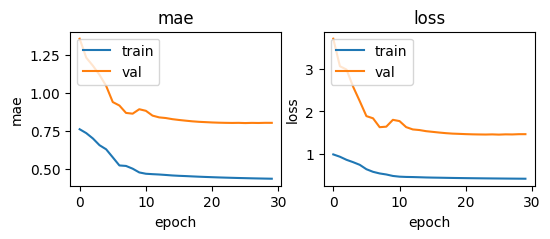

In [13]:
# Plot model history
plot_history(model_lstm_history, test_score, val_score)